### Analyzing pedestrian flows in Boston metro area

In [1]:
import os
import glob
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from ipywidgets import interact, widgets
import folium
from pyproj import Proj, transform

from interscity.grid import Grid

#### Loading data


Bike trips

In [2]:
trip_files = glob.glob('../../boston-ML/data/trips/2015*')
df_list = []
for f in trip_files:
    print(f)
    df = pd.read_csv(f, parse_dates=['starttime', 'stoptime'])
    df_list.append(df)
    
trips = pd.concat(df_list)

TRIP_COLUMNS = trips.columns

trips['starttime_loc'] = trips['starttime'].dt.tz_localize('US/Eastern', ambiguous=True)
trips['stoptime_loc'] = trips['stoptime'].dt.tz_localize('US/Eastern', ambiguous=True)
trips['start_day'] = trips['starttime_loc'].dt.to_period('d')
trips['stop_day'] = trips['stoptime_loc'].dt.to_period('d')

print(len(trips), 'trips')
trips.head(5)

../../boston-ML/data/trips/201503-hubway-tripdata.csv
../../boston-ML/data/trips/201504-hubway-tripdata.csv
67114 trips


tripduration           starttime            stoptime  start station id  \
0           337 2015-03-01 13:01:50 2015-03-01 13:07:27               108   
1           579 2015-03-01 14:27:08 2015-03-01 14:36:47               141   
2           423 2015-03-01 17:48:25 2015-03-01 17:55:29               141   
3           507 2015-03-01 19:14:50 2015-03-01 19:23:17                74   
4           271 2015-03-01 19:17:03 2015-03-01 19:21:35               116   

                                  start station name  start station latitude  \
0  Harvard University / SEAS Cruft-Pierce Halls a...               42.377945   
1                                     Kendall Street               42.363560   
2                                     Kendall Street               42.363560   
3                Harvard Square at Mass Ave/ Dunster               42.373268   
4          359 Broadway - Broadway at Fayette Street               42.370803   

   start station longitude end station id  \
0               -71.116865             88   
1               -71.082168             75   
2               -71.082168             75   
3               -71.118579             88   
4               -71.104412             96   

                                    end station name end station latitude  \
0      Inman Square at Vellucci Plaza / Hampshire St            42.374035   
1  Lafayette Square at Mass Ave / Main St / Colum...    42.36346469304347   
2  Lafayette Square at Mass Ave / Main St / Colum...    42.36346469304347   
3      Inman Square at Vellucci Plaza / Hampshire St            42.374035   
4  Cambridge Main Library at Broadway / Trowbridg...            42.373379   

  end station longitude  bikeid    usertype birth year  gender  \
0            -71.101427     769  Subscriber       1988       2   
1    -71.10057324171066    1300    Customer       1979       1   
2    -71.10057324171066    1094  Subscriber       1986       2   
3            -71.101427     800  Subscriber       1988       1   
4            -71.111075     644    Customer       1983       1   

              starttime_loc              stoptime_loc  start_day   stop_day  
0 2015-03-01 13:01:50-05:00 2015-03-01 13:07:27-05:00 2015-03-01 2015-03-01  
1 2015-03-01 14:27:08-05:00 2015-03-01 14:36:47-05:00 2015-03-01 2015-03-01  
2 2015-03-01 17:48:25-05:00 2015-03-01 17:55:29-05:00 2015-03-01 2015-03-01  
3 2015-03-01 19:14:50-05:00 2015-03-01 19:23:17-05:00 2015-03-01 2015-03-01  
4 2015-03-01 19:17:03-05:00 2015-03-01 19:21:35-05:00 2015-03-01 2015-03-01

Inspecting a data error:

* Expected all to be `float64`

In [3]:
for i in ['start station latitude', 'start station longitude', 'end station latitude', 'end station longitude']:
    print(trips[i].dtype)

float64
float64
object
object


* Expected all to be `int64`

In [4]:
for i in ['start station id', 'end station id']:
    print(trips[i].dtype)

int64
object


Fixing:

In [5]:
trips = trips[(trips['end station latitude'] != '\\N') & (trips['end station longitude'] != '\\N')]
trips['end station id'] = pd.to_numeric(trips['end station id'])
trips['end station latitude'] = pd.to_numeric(trips['end station latitude'])
trips['end station longitude'] = pd.to_numeric(trips['end station longitude'])

Stations

In [6]:
start_stations = trips[['start station id', 'start station name', 'start station latitude', 'start station longitude']]
start_stations.columns = ['id', 'sname', 'lat', 'lon']

end_stations = trips[['end station id', 'end station name', 'end station latitude', 'end station longitude']]
end_stations.columns = ['id', 'sname', 'lat', 'lon']

stations = pd.concat([start_stations, end_stations])
stations.drop_duplicates(subset='id', inplace=True)
                    
stations['sname'] = stations['sname'].str.replace("'", "&#8217;")
stations['geometry'] = stations.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
stations = gpd.GeoDataFrame(stations, crs={'init': 'epsg:4326'}).to_crs({'init': 'epsg:3395'})
stations.head()

id                                              sname        lat  \
0  108  Harvard University / SEAS Cruft-Pierce Halls a...  42.377945   
1  141                                     Kendall Street  42.363560   
3   74                Harvard Square at Mass Ave/ Dunster  42.373268   
4  116          359 Broadway - Broadway at Fayette Street  42.370803   
5   87  Harvard University Housing - 115 Putnam Ave at...  42.366621   

         lon                                      geometry  
0 -71.116865  POINT (-7916693.198613979 5188954.750716051)  
1 -71.082168   POINT (-7912830.737720471 5186795.24143057)  
3 -71.118579  POINT (-7916884.000221198 5188252.566326848)  
4 -71.104412   POINT (-7915306.93699513 5187882.503170213)  
5 -71.114214  POINT (-7916398.090643886 5187254.705345833)

Starting points

In [8]:
def parse_timestamps(row, field):
    return datetime.fromtimestamp(row[field] / 1e3)

start_points = pd.read_csv('pedestrian_trips/Starting_points.csv', delimiter=';')
start_points['start_time'] = start_points.apply(parse_timestamps, args=('startT',), axis=1)
start_points['start_day'] = start_points['start_time'].dt.to_period('d')
start_points['end_time'] = start_points.apply(parse_timestamps, args=('endT',), axis=1)
start_points['end_day'] = start_points['end_time'].dt.to_period('d')
start_points.head()

OBJECTID                            trajID    Rtype         startT  \
0         1  77d4fa9a96c6e0733a7731c75ecff4c9  walking  1428009826000   
1         2  24cc22eeff7e97e066b28a22500dfc23  walking  1428959897000   
2         3  982cbc7594f1967d817d5f43cf810a19  walking  1429368804000   
3         4  2b8f66a6d3d9f3c0abcf7fa627ca2a9e  walking  1428525659000   
4         5  fd98a69287693b0cffe112f48575a3d5  walking  1429208995000   

            endT                 Time  duration    Day Starttime  Year  \
0  1428010685000  2015-04-02 21:32:12     859.0  04-02  21:32:12  2015   
1  1428961779000  2015-04-13 21:46:51    1882.0  04-13  21:46:51  2015   
2  1429369472000  2015-04-18 14:58:21     668.0  04-18  14:58:21  2015   
3  1428527614000  2015-04-08 21:08:45    1955.0  04-08  21:08:45  2015   
4  1429210963000  2015-04-16 18:56:16    1968.0  04-16  18:56:16  2015   

     ...      month  shape_leng     speed  ORIG_FID    POINT_X    POINT_Y  \
0    ...          4         672  0.782305         0 -71.079378  42.367440   
1    ...          4        1359  0.722104         1 -71.119120  42.388506   
2    ...          4         472  0.706587         2 -71.113794  42.350969   
3    ...          4         108  0.055243         3 -71.017221  42.366206   
4    ...          4        2779  1.412090         4 -71.075908  42.347313   

           start_time  start_day            end_time    end_day  
0 2015-04-02 17:23:46 2015-04-02 2015-04-02 17:38:05 2015-04-02  
1 2015-04-13 17:18:17 2015-04-13 2015-04-13 17:49:39 2015-04-13  
2 2015-04-18 10:53:24 2015-04-18 2015-04-18 11:04:32 2015-04-18  
3 2015-04-08 16:40:59 2015-04-08 2015-04-08 17:13:34 2015-04-08  
4 2015-04-16 14:29:55 2015-04-16 2015-04-16 15:02:43 2015-04-16  

[5 rows x 21 columns]

Ending points 

In [9]:
end_points = pd.read_csv('pedestrian_trips/End_points.csv', delimiter=';')
end_points['start_time'] = end_points.apply(parse_timestamps, args=('startT',), axis=1)
end_points['start_day'] = end_points['start_time'].dt.to_period('d')
end_points['end_time'] = end_points.apply(parse_timestamps, args=('endT',), axis=1)
end_points['end_day'] = end_points['start_time'].dt.to_period('d')
end_points.head()

OBJECTID                            trajID    Rtype         startT  \
0         1  77d4fa9a96c6e0733a7731c75ecff4c9  walking  1428009826000   
1         2  24cc22eeff7e97e066b28a22500dfc23  walking  1428959897000   
2         3  982cbc7594f1967d817d5f43cf810a19  walking  1429368804000   
3         4  2b8f66a6d3d9f3c0abcf7fa627ca2a9e  walking  1428525659000   
4         5  fd98a69287693b0cffe112f48575a3d5  walking  1429208995000   

            endT                 Time  duration    Day Starttime  Year  \
0  1428010685000  2015-04-02 21:32:12     859.0  04-02  21:32:12  2015   
1  1428961779000  2015-04-13 21:46:51    1882.0  04-13  21:46:51  2015   
2  1429369472000  2015-04-18 14:58:21     668.0  04-18  14:58:21  2015   
3  1428527614000  2015-04-08 21:08:45    1955.0  04-08  21:08:45  2015   
4  1429210963000  2015-04-16 18:56:16    1968.0  04-16  18:56:16  2015   

     ...      month  shape_leng     speed  ORIG_FID    POINT_X    POINT_Y  \
0    ...          4         672  0.782305         0 -71.076642  42.370819   
1    ...          4        1359  0.722104         1 -71.115158  42.398027   
2    ...          4         472  0.706587         2 -71.109476  42.351415   
3    ...          4         108  0.055243         3 -71.017313  42.366960   
4    ...          4        2779  1.412090         4 -71.057497  42.355140   

           start_time  start_day            end_time    end_day  
0 2015-04-02 17:23:46 2015-04-02 2015-04-02 17:38:05 2015-04-02  
1 2015-04-13 17:18:17 2015-04-13 2015-04-13 17:49:39 2015-04-13  
2 2015-04-18 10:53:24 2015-04-18 2015-04-18 11:04:32 2015-04-18  
3 2015-04-08 16:40:59 2015-04-08 2015-04-08 17:13:34 2015-04-08  
4 2015-04-16 14:29:55 2015-04-16 2015-04-16 15:02:43 2015-04-16  

[5 rows x 21 columns]

Some verifications: 
* do they refer to the same trips?
  * yes
* how are durations calculated?
  * the difference between `startT` and `endT` timestamps, in seconds
* what's the meaning of `Time` field?
  * a time between `startT` and `endT` with some timestamp transformation
  * Boston timezone is GMT-05:00! The difference is 3 hours, though

In [10]:
assert len(start_points) == len(end_points)
assert start_points['trajID'].equals(end_points['trajID'])
assert start_points['startT'].equals(end_points['startT'])
assert start_points['endT'].equals(end_points['endT'])
assert (start_points['endT']/1e3 - start_points['startT']/1e3).equals(start_points['duration'])
assert (end_points['endT']/1e3 - end_points['startT']/1e3).equals(end_points['duration'])

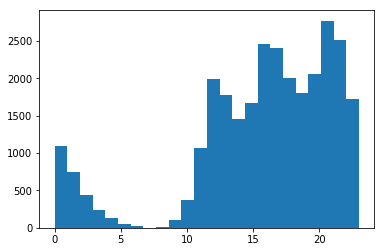

In [11]:
plt.hist(start_points['hour'], bins=24)
plt.show()

In [12]:
plt.hist(start_points['start_time'].dt.hour, bins=24)
plt.show()

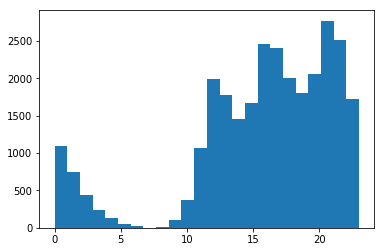

In [13]:
plt.hist(end_points['hour'], bins=24)
plt.show()

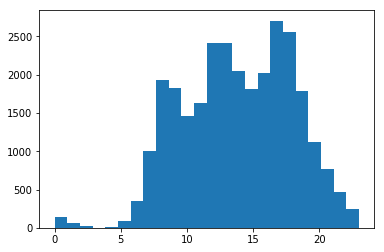

In [14]:
plt.hist(end_points['end_time'].dt.hour, bins=24)
plt.show()

#### Assumptions

* The most reliable time information are `startT` and `endT` fields
* As timestamps, they're given in UTC

In [15]:
start_points['start_time_local'] = start_points['start_time'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
start_points['end_time_local'] = start_points['end_time'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
end_points['start_time_local'] = start_points['start_time_local']  # as they're the same...
end_points['end_time_local'] = start_points['end_time_local']

### Matching bike trips and pedestrian trips

A pedestrian trip `p` is related to a bike trip `b` if:

```
((p.start_time - b.end_time) < 15 minutes) & dist(p.start_location, b.end_location) < 200m
|
((b.start_time - p.end_time)  < 15 minutes) & dist(p.start_location, b.end_location) < 200m
```

Steps:
* Generate GeoDataframes containing the pedestrian trips start and end points
* Convert them to a projection whose unit is the meter
* Create circles with radius of 200m from bike stations
* Perform a spatial join
  * Tried to calculate the distances in the cartesian product: too slow!
  * The circles approach is much, much more fast :)
* The only filter we have to do is by time closeness

Geodataframes:

In [16]:
def point_from_row(row):
    return Point(row['POINT_X'], row['POINT_Y'])

def generate_geodf(points_df):
    return gpd.GeoDataFrame(points_df, 
                 geometry=points_df.apply(point_from_row, axis=1),
                 crs={'init': 'epsg:4326'}).to_crs({'init': 'epsg:3395'})
    
starts_geo = generate_geodf(start_points)
ends_geo = generate_geodf(end_points)

In [17]:
starts_geo.head()

OBJECTID                            trajID    Rtype         startT  \
0         1  77d4fa9a96c6e0733a7731c75ecff4c9  walking  1428009826000   
1         2  24cc22eeff7e97e066b28a22500dfc23  walking  1428959897000   
2         3  982cbc7594f1967d817d5f43cf810a19  walking  1429368804000   
3         4  2b8f66a6d3d9f3c0abcf7fa627ca2a9e  walking  1428525659000   
4         5  fd98a69287693b0cffe112f48575a3d5  walking  1429208995000   

            endT                 Time  duration    Day Starttime  Year  \
0  1428010685000  2015-04-02 21:32:12     859.0  04-02  21:32:12  2015   
1  1428961779000  2015-04-13 21:46:51    1882.0  04-13  21:46:51  2015   
2  1429369472000  2015-04-18 14:58:21     668.0  04-18  14:58:21  2015   
3  1428527614000  2015-04-08 21:08:45    1955.0  04-08  21:08:45  2015   
4  1429210963000  2015-04-16 18:56:16    1968.0  04-16  18:56:16  2015   

                       ...                       ORIG_FID    POINT_X  \
0                      ...                              0 -71.079378   
1                      ...                              1 -71.119120   
2                      ...                              2 -71.113794   
3                      ...                              3 -71.017221   
4                      ...                              4 -71.075908   

     POINT_Y          start_time  start_day            end_time    end_day  \
0  42.367440 2015-04-02 17:23:46 2015-04-02 2015-04-02 17:38:05 2015-04-02   
1  42.388506 2015-04-13 17:18:17 2015-04-13 2015-04-13 17:49:39 2015-04-13   
2  42.350969 2015-04-18 10:53:24 2015-04-18 2015-04-18 11:04:32 2015-04-18   
3  42.366206 2015-04-08 16:40:59 2015-04-08 2015-04-08 17:13:34 2015-04-08   
4  42.347313 2015-04-16 14:29:55 2015-04-16 2015-04-16 15:02:43 2015-04-16   

           start_time_local            end_time_local  \
0 2015-04-02 13:23:46-04:00 2015-04-02 13:38:05-04:00   
1 2015-04-13 13:18:17-04:00 2015-04-13 13:49:39-04:00   
2 2015-04-18 06:53:24-04:00 2015-04-18 07:04:32-04:00   
3 2015-04-08 12:40:59-04:00 2015-04-08 13:13:34-04:00   
4 2015-04-16 10:29:55-04:00 2015-04-16 11:02:43-04:00   

                                       geometry  
0    POINT (-7912520.16490714 5187377.64956924)  
1  POINT (-7916944.224099114 5190540.526968119)  
2  POINT (-7916351.336480017 5184905.415648835)  
3   POINT (-7905600.879284508 5187192.40824054)  
4   POINT (-7912133.886185032 5184356.75267854)  

[5 rows x 24 columns]

Generate circles around bike stations:

In [18]:
MIN_DISTANCE = 200

stations['original_geometry'] = stations['geometry']
stations['geometry'] = stations.apply(lambda row: row['geometry'].buffer(MIN_DISTANCE), axis=1)
stations.head()

id                                              sname        lat  \
0  108  Harvard University / SEAS Cruft-Pierce Halls a...  42.377945   
1  141                                     Kendall Street  42.363560   
3   74                Harvard Square at Mass Ave/ Dunster  42.373268   
4  116          359 Broadway - Broadway at Fayette Street  42.370803   
5   87  Harvard University Housing - 115 Putnam Ave at...  42.366621   

         lon                                           geometry  \
0 -71.116865  POLYGON ((-7916493.198613979 5188954.750716051...   
1 -71.082168  POLYGON ((-7912630.737720471 5186795.24143057,...   
3 -71.118579  POLYGON ((-7916684.000221198 5188252.566326848...   
4 -71.104412  POLYGON ((-7915106.93699513 5187882.503170213,...   
5 -71.114214  POLYGON ((-7916198.090643886 5187254.705345833...   

                              original_geometry  
0  POINT (-7916693.198613979 5188954.750716051)  
1   POINT (-7912830.737720471 5186795.24143057)  
3  POINT (-7916884.000221198 5188252.566326848)  
4   POINT (-7915306.93699513 5187882.503170213)  
5  POINT (-7916398.090643886 5187254.705345833)

Spatial join:

In [19]:
starts_stations = gpd.sjoin(starts_geo, stations, op='within')
ends_stations = gpd.sjoin(ends_geo, stations, op='within')
print(len(starts_geo), len(starts_stations))
print(len(ends_geo), len(ends_stations))

28888 10019
28888 9980


In [20]:
starts_stations.head()

OBJECTID                            trajID    Rtype         startT  \
1           2  24cc22eeff7e97e066b28a22500dfc23  walking  1428959897000   
137       138  6a67771674c460ed924aadb924eff645  walking  1428867219000   
310       311  40399251639accb2893227ad7ee73745  walking  1429735107000   
655       656  ee5878d1ce6eb607e13ad0ca5d7d41b5  walking  1429232854000   
844       845  c79648149d6ca2ec06ac282957a43fc5  walking  1429739568000   

              endT                 Time  duration    Day Starttime  Year  \
1    1428961779000  2015-04-13 21:46:51    1882.0  04-13  21:46:51  2015   
137  1428869538000  2015-04-12 20:04:15    2319.0  04-12  20:04:15  2015   
310  1429737928000  2015-04-22 21:21:49    2821.0  04-22  21:21:49  2015   
655  1429233838000  2015-04-17 01:18:21     984.0  04-17  01:18:21  2015   
844  1429740127000  2015-04-22 21:57:43     559.0  04-22  21:57:43  2015   

                        ...                         end_day  \
1                       ...                      2015-04-13   
137                     ...                      2015-04-12   
310                     ...                      2015-04-22   
655                     ...                      2015-04-16   
844                     ...                      2015-04-22   

             start_time_local            end_time_local  \
1   2015-04-13 13:18:17-04:00 2015-04-13 13:49:39-04:00   
137 2015-04-12 11:33:39-04:00 2015-04-12 12:12:18-04:00   
310 2015-04-22 12:38:27-04:00 2015-04-22 13:25:28-04:00   
655 2015-04-16 17:07:34-04:00 2015-04-16 17:23:58-04:00   
844 2015-04-22 13:52:48-04:00 2015-04-22 14:02:07-04:00   

                                         geometry  index_right   id  \
1    POINT (-7916944.224099114 5190540.526968119)           23  115   
137  POINT (-7916826.782025196 5190322.938018208)           23  115   
310  POINT (-7916988.863170396 5190581.222356449)           23  115   
655  POINT (-7916958.361618784 5190443.369713137)           23  115   
844  POINT (-7916959.808838957 5190615.911052683)           23  115   

                     sname        lat        lon  \
1    Porter Square Station  42.387995 -71.119084   
137  Porter Square Station  42.387995 -71.119084   
310  Porter Square Station  42.387995 -71.119084   
655  Porter Square Station  42.387995 -71.119084   
844  Porter Square Station  42.387995 -71.119084   

                               original_geometry  
1    POINT (-7916940.21656405 5190463.792151546)  
137  POINT (-7916940.21656405 5190463.792151546)  
310  POINT (-7916940.21656405 5190463.792151546)  
655  POINT (-7916940.21656405 5190463.792151546)  
844  POINT (-7916940.21656405 5190463.792151546)  

[5 rows x 30 columns]

Inspecting bikestations and its related pedestrian trips

In [21]:
input_projection = Proj(init='epsg:3395')
output_projection = Proj(init='epsg:4326')

@interact(station=widgets.Dropdown(options=stations['sname'].sort_values(), value='MIT at Mass Ave / Amherst St'),
          pedestrian_trip=widgets.RadioButtons(options=['starts', 'ends']))
def pedestrian_trips_around_station(station, pedestrian_trip):
    # geometry (200m circle) immediately reprojected back to map
    selected = stations[stations['sname'] == station].to_crs({'init': 'epsg:4326'})
    station_area = selected['geometry'][selected.index[0]]
    minx, miny, maxx, maxy = station_area.bounds

    # original point needs to be reprojected
    station_point = selected['original_geometry'][selected.index[0]]
    station_x, station_y = transform(input_projection, output_projection, station_point.x, station_point.y)    
    
    boston_map = Grid(10, west_limit=minx, east_limit=maxx, south_limit=miny, north_limit=maxy) \
                 .map_around(zoom=17, plot_grid=False)
    folium.GeoJson(selected[['geometry']].to_json()).add_to(boston_map)
    folium.Marker(location=[station_y, station_x], icon=folium.Icon(color='black')).add_to(boston_map)
    
    if pedestrian_trip == 'starts':
        trip_points = starts_stations
    else:
        trip_points = ends_stations
        
    station_id = selected['id'][selected.index[0]]
    near_station_points = trip_points[trip_points['id'] == station_id].to_crs({'init': 'epsg:4326'})
    
    folium.GeoJson(near_station_points[['geometry']].to_json()).add_to(boston_map)
    display(boston_map)

interactive(children=(Dropdown(description='station', index=90, options=('18 Dorrance Warehouse', '359 Broadwa…

Matching with bike trips and filtering by time closeness:

*(Runned on server in a separate script due to time and memory consumption)*

* Pedestrian trips that end at bike trips starts

In [25]:
MIN_TIME_DIFF_MINUTES = 15

foot_bike = ends_stations[['trajID', 'end_day', 'end_time_local', 'id']] \
            .merge(trips, left_on=['id', 'end_day'], right_on=['start station id', 'start_day'])
foot_bike['time_diff'] = foot_bike['starttime_loc'] - foot_bike['end_time_local']
foot_bike = foot_bike[(foot_bike['time_diff'] >= pd.Timedelta(minutes=0)) & 
                      (foot_bike['time_diff'] <= pd.Timedelta(minutes=MIN_TIME_DIFF_MINUTES))]
foot_bike = foot_bike[['trajID'] + TRIP_COLUMNS.tolist()]
foot_bike.to_csv('output/pedestrian_to_bike.csv', index=False)
print(len(foot_bike), "'related' trips")
foot_bike.head()

1882 'related' trips


trajID  tripduration           starttime  \
30  c9fc9a888313440dce2dec2c83818c7b          1402 2015-04-02 11:34:42   
31  c9fc9a888313440dce2dec2c83818c7b          1414 2015-04-02 11:34:27   
32  c9fc9a888313440dce2dec2c83818c7b           909 2015-04-02 11:37:58   
97  4719c73b9fa50f2cbec4e79a7a89524e         64111 2015-04-19 14:46:27   
98  4719c73b9fa50f2cbec4e79a7a89524e         63860 2015-04-19 14:50:03   

              stoptime  start station id  \
30 2015-04-02 11:58:04                90   
31 2015-04-02 11:58:02                90   
32 2015-04-02 11:53:07                90   
97 2015-04-20 08:34:59                90   
98 2015-04-20 08:34:24                90   

                             start station name  start station latitude  \
30  Lechmere Station at Cambridge St / First St               42.370677   
31  Lechmere Station at Cambridge St / First St               42.370677   
32  Lechmere Station at Cambridge St / First St               42.370677   
97  Lechmere Station at Cambridge St / First St               42.370677   
98  Lechmere Station at Cambridge St / First St               42.370677   

    start station longitude  end station id  \
30               -71.076529              96   
31               -71.076529              96   
32               -71.076529              75   
97               -71.076529              90   
98               -71.076529              90   

                                     end station name  end station latitude  \
30  Cambridge Main Library at Broadway / Trowbridg...             42.373379   
31  Cambridge Main Library at Broadway / Trowbridg...             42.373379   
32  Lafayette Square at Mass Ave / Main St / Colum...             42.363465   
97        Lechmere Station at Cambridge St / First St             42.370677   
98        Lechmere Station at Cambridge St / First St             42.370677   

    end station longitude  bikeid    usertype birth year  gender  
30             -71.111075     784  Subscriber         \N       0  
31             -71.111075     984  Subscriber         \N       0  
32             -71.100573     892  Subscriber       1987       2  
97             -71.076529    1290  Subscriber         \N       0  
98             -71.076529    1001  Subscriber         \N       0

In [26]:
foot_bike.groupby('start station name').agg('count').bikeid.sort_values(ascending=False).to_csv("output/pedestrian_to_bike_numbers.csv")

* Bike trips that end at pedestrian trips starts

In [29]:
bike_foot = starts_stations[['trajID', 'start_day', 'start_time_local', 'id']] \
            .merge(trips, left_on=['id', 'start_day'], right_on=['end station id', 'stop_day'])
bike_foot['time_diff'] = bike_foot['start_time_local'] - bike_foot['stoptime_loc']
bike_foot = bike_foot[(bike_foot['time_diff'] >= pd.Timedelta(minutes=0)) & 
                      (bike_foot['time_diff'] <= pd.Timedelta(minutes=MIN_TIME_DIFF_MINUTES))]
bike_foot = bike_foot[['trajID'] + TRIP_COLUMNS.tolist()]
bike_foot.to_csv('output/bike_to_pedestrian.csv', index=False)
print(len(bike_foot), "'related' trips")
bike_foot.head()

2240 'related' trips


trajID  tripduration           starttime  \
5   24cc22eeff7e97e066b28a22500dfc23          1115 2015-04-13 12:44:47   
7   24cc22eeff7e97e066b28a22500dfc23           327 2015-04-13 13:08:30   
50  df4b0c85b6291bb6092ea6641c3ad9ab          1075 2015-04-13 16:31:47   
51  df4b0c85b6291bb6092ea6641c3ad9ab           269 2015-04-13 16:37:49   
97  e25a877f84f7287f47e8d57009f1d5ee           789 2015-04-13 08:22:33   

              stoptime  start station id  \
5  2015-04-13 13:03:22               105   
7  2015-04-13 13:13:57               108   
50 2015-04-13 16:49:43                90   
51 2015-04-13 16:42:19               140   
97 2015-04-13 08:35:42               140   

                                   start station name  start station latitude  \
5     Lower Cambridgeport at Magazine St/Riverside Rd               42.356954   
7   Harvard University / SEAS Cruft-Pierce Halls a...               42.377945   
50        Lechmere Station at Cambridge St / First St               42.370677   
51                                        Danehy Park               42.388966   
97                                        Danehy Park               42.388966   

    start station longitude  end station id       end station name  \
5                -71.113687             115  Porter Square Station   
7                -71.116865             115  Porter Square Station   
50               -71.076529             115  Porter Square Station   
51               -71.132788             115  Porter Square Station   
97               -71.132788             115  Porter Square Station   

    end station latitude  end station longitude  bikeid    usertype  \
5              42.387995             -71.119084    1278    Customer   
7              42.387995             -71.119084     663  Subscriber   
50             42.387995             -71.119084    1283  Subscriber   
51             42.387995             -71.119084    1111  Subscriber   
97             42.387995             -71.119084    1096  Subscriber   

   birth year  gender  
5        1973       1  
7          \N       0  
50       1977       1  
51       1982       1  
97       1975       1

In [30]:
bike_foot.groupby('start station name').agg('count').bikeid.sort_values(ascending=False).to_csv("output/bike_to_pedestrian_numbers.csv")

It was difficult to find a match! After bring 2015 bike trips, let's inspect bike and pedestrian trips proximity.

* Pedestrian stops and bike starts

In [ ]:
end_points['end_day'].min(), end_points['end_day'].max()

In [ ]:
trips['start_day'].min(), trips['start_day'].max()

* Bike stops and pedestrian starts

In [ ]:
start_points['start_day'].min(), start_points['start_day'].max()

In [ ]:
trips['stop_day'].min(), trips['stop_day'].max()